# Tarea 0.1

## Explicación

## Tiempo medio de absorción

In [2]:
import random
import pandas as pd
import numpy as np

# def print_possible_routes(states: list[int], current_state: int) -> None:
#     states: set = set(states)
#     current_states: list[int] = random.sample(sorted(states), current_state)
#     count: int = 0
#     for target1 in states:
#         for target2 in states:
#             if target1 != current_states[0] and target2 != current_states[1]:
#                 print(f"{current_states[0]} -> {target1} | {current_states[1]} -> {target2}")
#                 count += 1
#     print("Total routes:", count)

def sumit(it) -> float:
    count = 0
    for i in it:
        count += i
    return count

def possible_routes(states: list[int], current_state: int) -> tuple[list[list[int]], list[int]]:
    n_states: int = len(states)
    current_states: list[int] = random.sample(sorted(states), current_state)
    count: int = 0

    targets_list: list[list[int]] = [states for t in range(current_state, 2*current_state + 1)]
    counters: list[int] = [0 for _ in range(current_state)]
    # print(counters, len(counters))

    i: int = 0
    transitions: list[list[int]] = []
    while i < (n_states) ** current_state:
        for current in range(len(current_states)):
            to_print: str = ""
            valid: bool = True
            j: int = 0
            temp: list[int] = [] #*List to store the target values
            for c in counters:
                # print(c)
                if current_states[j] != targets_list[j][c]:
                    to_print += f"{current_states[j]} -> {targets_list[j][c]} | "
                    temp.append(targets_list[j][c])
                    j += 1
                else:
                    valid = False
            if valid:
                # print(to_print)
                transitions.append(temp)
                count += 1
            sum: int = 1
            # print("Sum:", sumit(counters), count)
            for c in range(current_state):
                counters[c] += sum
                if counters[c] >= n_states:
                    counters[c] = 0
                    sum = 1
                else:
                    sum = 0
            if sumit(counters) == 0:
                # print(count)
                return transitions, current_states
            i += 1
    # print(count)

def get_classes(routes: pd.DataFrame, current_states: list[int]) -> list[pd.DataFrame]:
    df = pd.DataFrame(routes, columns=[i for i in current_states])
    df['class'] = 0
    for row in range(len(routes)):
        new_states = set(current_states)
        for state in range(len(current_states)):
            target_state = routes.iloc[row, state]
            if target_state not in new_states:
                df.at[row, 'class'] += 1
                new_states.add(target_state)
    return df

    # for tlist in targets_list:
    #     for target in tlist:
    #         if target1 != current_states[0] and target2 != current_states[1]:
    #             print(f"{current_states[0]} -> {target1} | {current_states[1]} -> {target2}")
    #             count += 1

    # for target1 in states:
    #     for target2 in states:
    #         if target1 != current_states[0] and target2 != current_states[1]:
    #             print(f"{current_states[0]} -> {target1} | {current_states[1]} -> {target2}")
    #             count += 1
    # print("Total routes:", count)

def print_classes_summary(classes: pd.DataFrame) -> None:
    unique_classes = list(classes['class'].unique())
    unique_classes = sorted([int(x) for x in unique_classes])
    n_class_rows: list[int] = []
    for class_val in unique_classes:
        class_rows = classes[classes['class'] == class_val]
        n_class_rows.append(len(class_rows))
        print(f"Class {class_val}):")
        print(class_rows)
        print()
    print(unique_classes)
    for class_val in range(len(unique_classes)):
        print(f"Class {unique_classes[class_val]} has {n_class_rows[class_val]} elements")
    print(f"The total sum of elements in the {len(unique_classes)} classes is {sumit(n_class_rows)}")

def solve_system(A: np.array, b:np.array) -> np.array:
    solution: np.array = np.linalg.solve(a=A, b=b)
    return solution

def build_transition_matrix(n: int = 2) -> np.array:
    if n < 2:
        raise ValueError("n must be greater than or equal to 2")
    states: list[int] = [s for s in range(1, n + 1)]
    P: np.array = np.zeros(shape=(n, n))
    for s in states:
        routes, current_states = possible_routes(states, current_state=s)
        routes_df = pd.DataFrame(routes, columns=current_states)
        # print("Routes", routes_df)
        # print("States", current_states)
        classes: pd.DataFrame = get_classes(routes_df, current_states)
        unique_classes: list = list(classes['class'].unique())
        unique_classes = sorted([int(x) for x in unique_classes])

        for c in unique_classes:
            class_count = len(classes[classes['class'] == c])
            probability = class_count / ((n-1)**s)
            P[s-1][(s-1) + c] = probability
            # print(f"P[{s-1}][{(s-1) + c}] = {class_count} / {(n-1)**s} = {probability}")
    
    #*Verify that each row sums to 1
    for i in range(n):
        row_sum = np.sum(P[i])
        if not np.isclose(row_sum, 1):
            print(f"Warning, row {i}'s : {P[i]} entries do not sum 1")

    return P

def compute_transition_matrix(n: int) -> np.ndarray:
    """
    Computes the transition probability matrix P for the rumor-spreading Markov chain.

    P[i][j] is the probability of transitioning from i+1 informed hosts to j+1 informed hosts.
    """
    # Initialize an n x n matrix with zeros.
    P = np.zeros((n, n))

    for i in range(1, n + 1):  # Current number of informed hosts (state)
        # 0-based index for the matrix row
        row_idx = i - 1

        # If all hosts are informed, it's an absorbing state.
        if i == n:
            P[row_idx][row_idx] = 1.0
            continue

        # dp[k] = probability of informing k NEW hosts
        # The max number of new hosts is i.
        dp = np.zeros(i + 1)
        dp[0] = 1.0  # Initially, 0 new hosts are informed with probability 1.

        # Iterate through each of the i hosts making a call
        for c in range(i):
            new_dp = np.zeros(i + 1)
            # Iterate through the possible numbers of newly informed hosts so far
            for k in range(c + 1):
                if dp[k] == 0:
                    continue

                # Number of uninformed hosts remaining
                num_uninformed_left = n - i - k
                
                # Probability of the current caller hitting a new host
                prob_hit_new = num_uninformed_left / (n - 1)
                
                # Probability of hitting an already-informed host
                prob_hit_old = 1.0 - prob_hit_new

                # Update probabilities for the next step
                # Case 1: An old host is hit -> number of new hosts remains k
                new_dp[k] += dp[k] * prob_hit_old
                # Case 2: A new host is hit -> number of new hosts becomes k+1
                if k + 1 <= i:
                    new_dp[k + 1] += dp[k] * prob_hit_new
            dp = new_dp
        
        # After all i hosts have called, populate the transition matrix row
        for k in range(i + 1):
            # j is the total number of informed hosts at the end
            j = i + k
            if j <= n:
                col_idx = j - 1
                P[row_idx][col_idx] = dp[k]

    return P

def calculate_t_jn(n: int, P: np.array) -> np.array:
    valid_states = [i for i in range(n-1)]
    submatrix = np.zeros((n-1, n-1), dtype=float)
    ones = np.ones(n-1, dtype=float)

    for r, i in enumerate(valid_states):
        for c, d in enumerate(valid_states):
            if i == d:
                submatrix[r, c] = 1.0 - P[i, i] # Notice that we can always factor the ti,j that we want to calculate. See in the example that t_1,0 is at the left and right side of the equation.
            else:
                submatrix[r, c] = - P[i, d] # Else, the matrix entrance will be the probability taken to the left side of the equation

    sol_vector = np.linalg.solve(submatrix, ones)
    return sol_vector

if __name__ == "__main__":
    routes, current_states = possible_routes([n for n in range(1, 6)], 1)
    df = pd.DataFrame(routes, columns=[i for i in current_states])
    classes = get_classes(df, current_states)
    # print_classes_summary(classes)
    A = np.array([[-1, 1, 0, 0],
               [0, -15/16, 9/16, 6/16],
               [0, 0, -28/32, 19/32],
               [0, 0, 0, -81/256]])
    b = np.array([-1, -1, -1, -1])
    print(solve_system(A, b))
    P: np.array = compute_transition_matrix(5)
    print(P)
    ts: np.array = calculate_t_jn(5, P)
    print(f"t_{1},{5} = {ts[0]}")


[5.30335097 4.30335097 3.28747795 3.16049383]
[[0.         1.         0.         0.         0.        ]
 [0.         0.0625     0.5625     0.375      0.        ]
 [0.         0.         0.125      0.59375    0.28125   ]
 [0.         0.         0.         0.31640625 0.68359375]
 [0.         0.         0.         0.         1.        ]]
t_1,5 = 3.933115646258503


In [3]:
!pip install matplotlib

In [139]:
def get_atimes(max_n: int, silent: bool = 1) -> np.array:
    atime_arr: np.array = np.zeros(max_n)
    for n in range(1, max_n):
        if not silent:
            print(n+1)
        P: np.array = compute_transition_matrix(n+1)
        ts: np.array = calculate_t_jn(n+1, P)
        atime_arr[n] = ts[0]
    return atime_arr

def plot_atimes(max_n: int, func_params: list[float] = None, plot_guess: bool = False) -> None:
    atime_arr: np.array = get_atimes(max_n)

    import matplotlib.pyplot as plt

    x_size: int = 0
    if max_n * 0.05 > 25:
        x_size = 25
    elif max_n * 0.05 > 20:
        x_size = 20
    elif max_n * 0.05 > 15:
        x_size = 15
    else:
        x_size = 10
    plt.figure(figsize=(x_size, 5))

    #*Plot mean absorption time
    plt.plot(range(1, max_n + 1), atime_arr, marker='o', label='Tiempo medio de absorción')

    #*Plot base-10 logarithmic function for comparison
    x = np.arange(1, max_n + 1)
    # x = np.linspace(1, max_n, 200) #*In case we want to smooth the function
    plt.plot(x, 3*np.log(x), label='log(n)', linestyle='--')

    if func_params is not None and len(func_params) == 3:
        #*Plot best-fitting logarithmic function for guess
        a, b, c = func_params
        plt.plot(x, c * (np.log(a*x)/np.log(b)), label=f'{round(c,2)} * log_{round(b,2)}({round(a,2)} * n)')

    if plot_guess:
        #*Plot 6*log_10(n)
        plt.plot(x, 6.1 * np.log(0.999999999999*x)/np.log(9.99999999999999), label=f'6*log_10(n)')

    plt.xlabel('n')
    plt.ylabel('Tiempo medio de absorción')
    plt.title('Tiempo medio de absorción vs n (número de estados)')
    plt.grid(True)
    plt.legend()
    plt.show()


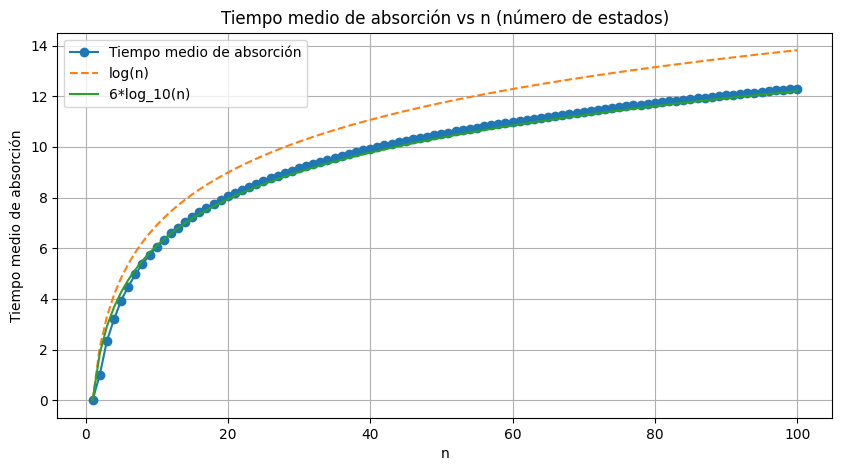

In [140]:
plot_atimes(100, plot_guess=True)

## Comprobación estadística

Decidimos hacer una simulación con todos los estados posibles, marcándolos como visitados o no, haciendo la escogencia de pasar un mensaje a otro igual como en el problema, con probabilidad $\frac{1}{n-1}$. Cuando todos los equipos tengan el mensaje se detiene la simulación. 

Se hizo un total de 200 pruebas por cada n, que varía de 2 a 200 y se ve que se obtienen unos resultados muy similares a los obtenidos previamente. Al comparar la gráfica obtenida con $2*log_2(n)$ vemos que tienen una tendencia similar

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


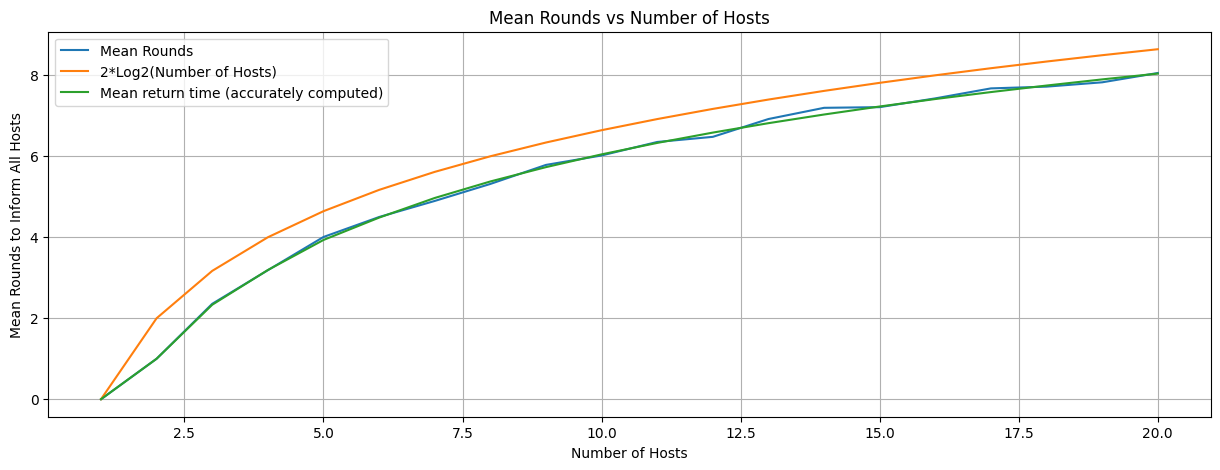

In [ ]:
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Host:
    def __init__(self):
        self.is_informed = False
        self.neighbours = []
    
    def add_n(self, hosts):
        for h in hosts.are_informed.keys():
            if h != self:
                self.neighbours.append(h)
                
class Hosts:
    def __init__(self, size):
        self.size = size
        self.are_informed = {}
        
    def add(self, host):
        self.are_informed[host] = False
    
    def complete(self):
        for h in self.are_informed.keys():
            if not self.are_informed[h]:
                return False
        return True


def simulate(size, n_simulations):
    rounds_needed = []
    for _ in range(n_simulations):
        hosts = Hosts(size)
        for _ in range(size):
            h = Host()
            hosts.add(h)
        for h in hosts.are_informed.keys():
            h.add_n(hosts)
        initial_informed = random.choice(list(hosts.are_informed.keys()))
        hosts.are_informed[initial_informed] = True
        initial_informed.is_informed = True
        rounds = 0
        while not hosts.complete():
            rounds += 1
            new_informed = []
            for h in hosts.are_informed.keys():
                if h.is_informed:
                    if h.neighbours:
                        chosen = random.choice(h.neighbours)
                        if not chosen.is_informed:
                            new_informed.append(chosen)
            for h in new_informed:
                hosts.are_informed[h] = True
                h.is_informed = True
        rounds_needed.append(rounds)
    return np.mean(rounds_needed)

max_n: int = 21
n_simulations: int = 100
sizes = list(range(2, max_n))
means = [simulate(size, n_simulations) for size in sizes]
sizes = [1] + sizes
means = [0.0] + means
df = pd.DataFrame({'size': sizes, 'mean_rounds': means})

# add log_2 n graph to compare
df['log_n'] = 2*np.log2(df['size'])

# add mean return times calculated earlier to compare
atimes_arr: np.array = get_atimes(max_n-1, 0)

plt.figure(figsize=(15, 5))

plt.plot(sizes, means, label='Mean Rounds')
plt.plot(sizes, df['log_n'], label='2*Log2(Number of Hosts)')
plt.plot(sizes, atimes_arr, label='Mean return time (accurately computed)')
plt.xlabel('Number of Hosts')
plt.ylabel('Mean Rounds to Inform All Hosts')
plt.title('Mean Rounds vs Number of Hosts')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def distance_function(params: list[float], x_data, y_data):
    a, b, c = params
    if b <= 0 or b == 1 or a <= 0:  #*Invalid log parameters
        return np.inf
    
    try:
        predicted = c * np.log(a * x_data) / np.log(b)  #* log_b(a*n) = log_d(a*n)/log_d(b)
        return np.mean((y_data - predicted) ** 2)  #*MSE
    except:
        return np.inf

def fit_log(atimes_arr: np.array) -> list[float]:
    """
    The idea is to make a grid search for the best parameters of f(n) = c * log_b(a*n),
    where b will be the base of the logarithm
    """
    
    n_values = np.arange(1, len(atimes_arr) + 1)
    
    #*Remove zero values for log fitting
    y_data = atimes_arr[1:]
    x_data = n_values[1:]
    
    def distance_function(params):
        a, b, c = params
        if b <= 0 or b == 1 or a <= 0:  #*Invalid log parameters
            return np.inf
        
        try:
            predicted = c * np.log(a * x_data) / np.log(b)  #* log_b(a*n) = log_d(a*n)/log_d(b)
            return np.mean((y_data - predicted) ** 2)  #*MSE
        except:
            return np.inf
    
    best_params = None
    best_distance = np.inf
    
    #*Base grid search
    for a in np.linspace(0.1, 5.0, 10):
        for b in [2, np.e, 10]:
            for c in np.linspace(0.1, 10.0, 20):
                distance = distance_function([a, b, c])
                if distance < best_distance:
                    best_distance = distance
                    best_params = [a, b, c]
    
    #*Fine-tune with optimization
    if best_params is not None:
        result = minimize(distance_function, best_params, 
                         bounds=[(0.65, 1), (2, 10), (0.01, 15)])
        if result.success:
            best_params = result.x
            best_distance = result.fun
    
    return list(best_params) + [best_distance]

if __name__ == "__main__":
    max_n: int = 250
    atimes_arr = get_atimes(max_n)
    a, b, c, best_dist = fit_log(atimes_arr)
    plot_atimes(max_n, [a, b, c])
    print(f"Average best distance of the best-fitting log function: {best_dist}")
    

In [115]:
atimes_arr = get_atimes(20)
print(f"Distance from guess log_10(n) to data: {distance_function([1, 10, 6], np.arange(1, len(atimes_arr) + 1), atimes_arr)}")

Distance from guess log_10(n) to data: 0.07721214088792826


## Conjetura